### Deep Learning - Neural Networks
## Project : ImageNet Classification
### Deepthi D'Souza



### ImageNet
ImageNet is a large visual database with more than 14 million human annotated images
and 20k classes designed for developing computer vision algorithms. ImageNet Large
Scale Visual Recognition Challenge (ILSVRC) led to developing a number of state-of-
the-art algorithms. For the project we would work on a limited number of classes.


### Steps Followed:

1. Choose at least 10 classes from ImageNet. Each class has to contain at least
500 images.
2. Download the dataset (see above for the links to downloader scripts).
3. Preprocess the dataset for training (e.g. removing missing images, normalizing,
split between training/testing/validation)
4. Build a CNN classifier with at least 3 convolutional layers to train on an ImageNet
dataset that you have collected. You may follow AlexNet CNN architecture to
build a CNN model.
5. Apply following techniques to prevent overfitting and improve the results. Discuss
each of the techniques you have used and how they impact the performance:
- a. Regularization: Apply regularization techniques, such as L1 or L2
regularization, to the model's parameters.
- b. Dropout: Introduce dropout layers between the fully connected layers.
- c. Early stopping: Monitor the performance of the model on a validation set
and stop training when the validation loss stops improving.
- d. Image augmentation
- e. Expected min accuracy: 70%
6. Save the weights of the trained neural network that provides the best results.
Check saving and loading models (PyTorch)
7. Discuss the results and provide relevant graphs:
- Report training accuracy, training loss, validation accuracy, validation loss,
testing accuracy, and testing loss.
- Plot the training and validation accuracy over time (epochs).
- Plot the training and validation loss over time (epochs).
- Generate a confusion matrix using the model's predictions on the test set.
- Calculate and report other evaluation metrics such as precision, recall,
and F1 score to further analyze the model's performance on the test set.

## Step 1: Importing Required Libraries and Imagenet dataset

### Mounting on drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Importing libraries and Dataset

In [2]:
import zipfile
import os
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import pickle
import torch
import h5py
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
filename = "/content/drive/MyDrive/imagenet_classes.zip"
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("imagenet/")

zip_ref.close()

In [5]:
import os
import shutil
import random

# Set the random seed for reproducibility
random.seed(42)

# Define the path to the original dataset
data_dir = '/content/imagenet/imagenet_classes/'

selected_classes = ['rock climbing', 'swimming', 'archery', 'sumo', 'fishing', 'rugby', 'cricket', 'badminton', 'gymnastics', 'cliff diving']

# Define the path to the new dataset
new_dir = 'imagenet_split'

if os.path.exists(new_dir):
    shutil.rmtree(new_dir)

# Define the names of the new folders
train_dir = os.path.join(new_dir, 'train')
test_dir = os.path.join(new_dir, 'test')
val_dir = os.path.join(new_dir, 'validation')

# Create the new folders
os.makedirs(train_dir)
os.makedirs(test_dir)
os.makedirs(val_dir)

# Define the categories in the dataset
categories = ['rock climbing', 'swimming', 'archery', 'sumo', 'fishing', 'rugby', 'cricket', 'badminton', 'gymnastics', 'cliff diving']

# Split the data into training and testing sets
for category in categories:
    # Create the subfolders in the new folders
    os.makedirs(os.path.join(train_dir, category))
    os.makedirs(os.path.join(test_dir, category))
    os.makedirs(os.path.join(val_dir, category))

    # Get the filenames for the category
    filenames = os.listdir(os.path.join(data_dir, category))

    # Shuffle the filenames
    random.shuffle(filenames)

    # Split the filenames into training and testing sets
    split_idx = int(0.7 * len(filenames))
    test_val_splt_indx = int(0.85 * len(filenames))
    train_filenames = filenames[:split_idx]
    test_filenames = filenames[split_idx:test_val_splt_indx]
    val_filenames = filenames[test_val_splt_indx:]

    # Copy the files to the new folders
    for filename in train_filenames:
        src = os.path.join(data_dir, category, filename)
        dst = os.path.join(train_dir, category, filename)
        shutil.copy(src, dst)

    for filename in test_filenames:
        src = os.path.join(data_dir, category, filename)
        dst = os.path.join(test_dir, category, filename)
        shutil.copy(src, dst)

    for filename in val_filenames:
        src = os.path.join(data_dir, category, filename)
        dst = os.path.join(val_dir, category, filename)
        shutil.copy(src, dst)

### Data Pre processing and data split

In [6]:
# Define the transformations for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# # Load the dataset using ImageFolder
# dataset = ImageFolder(data_dir, transform=transform)

# Load the data from the folders
train_data = datasets.ImageFolder('imagenet_split/train', transform=transform)
test_data = datasets.ImageFolder('imagenet_split/test', transform=transform)
val_data = datasets.ImageFolder('imagenet_split/validation', transform=transform)

# Define the data loaders to load the data in batches during training and testing
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


### Plot

In [8]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, test_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'g', label='Training accuracy')
    plt.plot(epochs, test_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss over time')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Step 2. Building Base CNN

### CNN network architecture for base model

In [10]:
import torch
import torch.nn as nn

class AlexNet_base(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_base, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of the AlexNet model
model_base = AlexNet_base(num_classes=10)

# Print the model architecture
print(model_base)


AlexNet_base(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=

### Train validate and test for base model

Epoch [1/15], Train Loss: 1.5939, Train Accuracy: 81.82%, Val Loss: 1.6724, Val Accuracy: 37.96%
Epoch [2/15], Train Loss: 2.1544, Train Accuracy: 81.82%, Val Loss: 1.4690, Val Accuracy: 47.89%
Epoch [3/15], Train Loss: 1.0095, Train Accuracy: 90.91%, Val Loss: 1.3239, Val Accuracy: 54.55%
Epoch [4/15], Train Loss: 1.2011, Train Accuracy: 72.73%, Val Loss: 1.1678, Val Accuracy: 59.70%
Epoch [5/15], Train Loss: 1.1516, Train Accuracy: 81.82%, Val Loss: 1.1084, Val Accuracy: 62.89%
Epoch [6/15], Train Loss: 0.7840, Train Accuracy: 63.64%, Val Loss: 1.1646, Val Accuracy: 59.98%
Epoch [7/15], Train Loss: 0.7419, Train Accuracy: 72.73%, Val Loss: 1.0345, Val Accuracy: 64.29%
Epoch [8/15], Train Loss: 0.8116, Train Accuracy: 72.73%, Val Loss: 1.0050, Val Accuracy: 66.17%
Epoch [9/15], Train Loss: 0.7701, Train Accuracy: 72.73%, Val Loss: 0.9088, Val Accuracy: 70.29%
Epoch [10/15], Train Loss: 0.5966, Train Accuracy: 100.00%, Val Loss: 0.9175, Val Accuracy: 68.79%
Epoch [11/15], Train Loss: 0

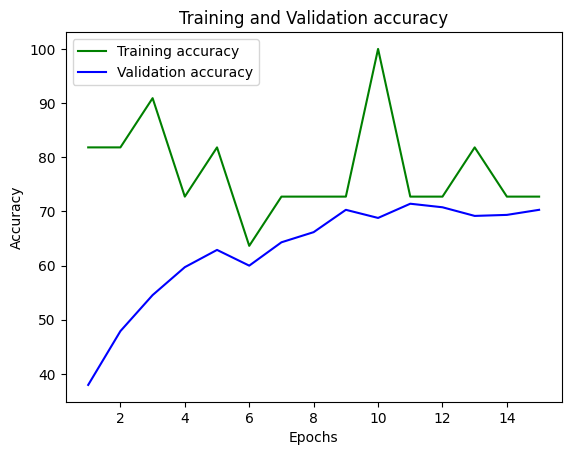

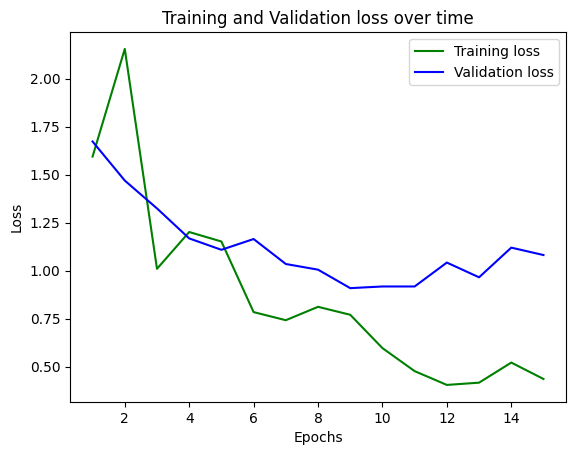

In [10]:
def train_val_test_base(model_base,train_loader,val_loader,test_loader):
  # Define the hyperparameters
  learning_rate = 0.0001
  num_epochs = 15

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_base.parameters(), lr=learning_rate)

  train_acc_list = []
  val_acc_list = []
  train_loss_list = []
  val_loss_list = []
  train_total = 0
  val_total = 0

  # Training loop
  for epoch in range(num_epochs):
      model_base.train()  # Set the model to training mode

      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model_base(images)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

      # Validation loop
      model_base.eval()  # Set the model to evaluation mode
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad():
          for images, labels in val_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = model_base(images)
              val_loss += criterion(outputs, labels).item()

              _, predicted = torch.max(outputs, 1)
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()

      # Print the training and validation loss, and accuracy for each epoch
      train_loss = loss.item()
      train_accuracy = 100.0 * (predicted == labels).sum().item() / labels.size(0)
      train_acc_list.append(train_accuracy)
      train_loss_list.append(train_loss)

      val_loss /= len(val_loader)
      val_accuracy = 100.0 * val_correct / val_total
      val_loss_list.append(val_loss)
      val_acc_list.append(val_accuracy)

      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

  # Test the model
  model_base.eval()  # Set the model to evaluation mode
  test_correct = 0
  test_total = 0
  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)

          outputs = model_base(images)

          _, predicted = torch.max(outputs, 1)
          test_total += labels.size(0)
          test_correct += (predicted == labels).sum().item()

          all_predictions.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Calculate the test accuracy
  test_accuracy = 100.0 * test_correct / test_total
  print(f"Test Accuracy: {test_accuracy:.2f}%")

  # Generate confusion matrix
  cm = confusion_matrix(all_labels, all_predictions)
  print("Confusion Matrix:")
  print(cm)

  # Calculate precision, recall, and F1 score
  report = classification_report(all_labels, all_predictions)
  print("Classification Report:")
  print(report)
  plot_accuracy(train_acc_list,val_acc_list)
  plot_loss(train_loss_list,val_loss_list)

  return model_base.state_dict()


# Create an instance of the AlexNet model
model_base = AlexNet_base(num_classes=10).to(device)
model_weights = train_val_test_base(model_base,train_loader,val_loader,test_loader)

# save weights in pickle file
pickle_out = open("model_base.pickle", "wb")
pickle.dump(model_weights, pickle_out)
pickle_out.close()


## Step 3: Applying Various Transformations on the Base Model

### 1. Regularization


Epoch [1/15], Train Loss: 1.5484, Train Accuracy: 81.82%, Val Loss: 1.6248, Val Accuracy: 41.24%
Epoch [2/15], Train Loss: 1.4900, Train Accuracy: 81.82%, Val Loss: 1.4316, Val Accuracy: 49.86%
Epoch [3/15], Train Loss: 1.3275, Train Accuracy: 81.82%, Val Loss: 1.2629, Val Accuracy: 55.76%
Epoch [4/15], Train Loss: 1.4884, Train Accuracy: 81.82%, Val Loss: 1.1655, Val Accuracy: 59.70%
Epoch [5/15], Train Loss: 0.6356, Train Accuracy: 81.82%, Val Loss: 1.0709, Val Accuracy: 62.89%
Epoch [6/15], Train Loss: 0.7872, Train Accuracy: 72.73%, Val Loss: 0.9959, Val Accuracy: 66.92%
Epoch [7/15], Train Loss: 1.1276, Train Accuracy: 72.73%, Val Loss: 0.9773, Val Accuracy: 68.04%
Epoch [8/15], Train Loss: 0.6814, Train Accuracy: 72.73%, Val Loss: 0.9454, Val Accuracy: 70.10%
Epoch [9/15], Train Loss: 0.7233, Train Accuracy: 72.73%, Val Loss: 1.0045, Val Accuracy: 68.23%
Epoch [10/15], Train Loss: 0.5238, Train Accuracy: 72.73%, Val Loss: 0.9109, Val Accuracy: 72.07%
Epoch [11/15], Train Loss: 0.

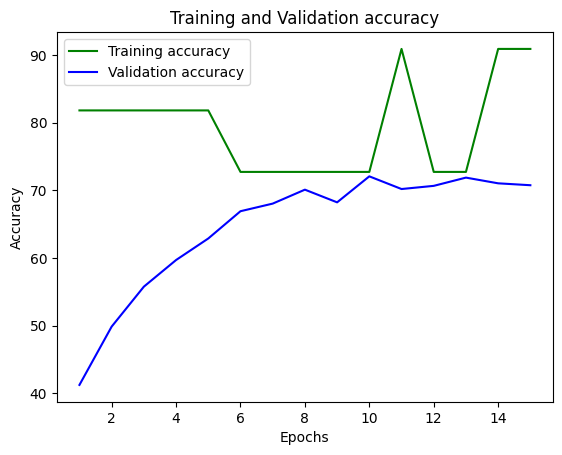

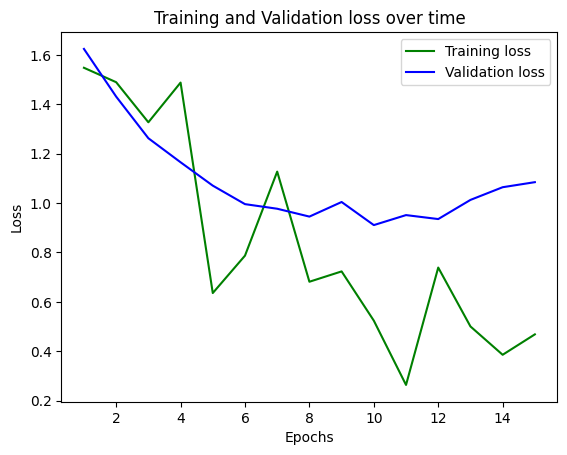

In [11]:
def train_val_test_reg(model_reg, train_loader,val_loader,test_loader):

  # Define the hyperparameters
  learning_rate = 0.0001
  num_epochs = 15

  # Define the loss function
  criterion = nn.CrossEntropyLoss()
  # Define the regularization strength
  weight_decay = 1e-5
  # Define the optimizer with L2 regularization
  optimizer = optim.Adam(model_reg.parameters(), lr=learning_rate, weight_decay=weight_decay)

  train_acc_list = []
  val_acc_list = []
  train_loss_list = []
  val_loss_list = []
  train_total = 0
  val_total = 0


  # Training loop
  for epoch in range(num_epochs):
      model_reg.train()  # Set the model to training mode

      for images, labels in train_loader:
          images = images.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model_reg(images)
          loss = criterion(outputs, labels)

          loss.backward()
          optimizer.step()

      # Validation loop
      model_reg.eval()  # Set the model to evaluation mode
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad():
          for images, labels in val_loader:
              images = images.to(device)
              labels = labels.to(device)

              outputs = model_reg(images)
              val_loss += criterion(outputs, labels).item()

              _, predicted = torch.max(outputs, 1)
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()

      # Print the training and validation loss, and accuracy for each epoch
      train_loss = loss.item()
      train_accuracy = 100.0 * (predicted == labels).sum().item() / labels.size(0)
      train_acc_list.append(train_accuracy)
      train_loss_list.append(train_loss)

      val_loss /= len(val_loader)
      val_accuracy = 100.0 * val_correct / val_total
      val_loss_list.append(val_loss)
      val_acc_list.append(val_accuracy)

      print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

  # Test the model
  model_reg.eval()  # Set the model to evaluation mode
  test_correct = 0
  test_total = 0
  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)

          outputs = model_reg(images)

          _, predicted = torch.max(outputs, 1)
          test_total += labels.size(0)
          test_correct += (predicted == labels).sum().item()

          all_predictions.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Calculate the test accuracy
  test_accuracy = 100.0 * test_correct / test_total
  print(f"Test Accuracy: {test_accuracy:.2f}%")

  # Generate confusion matrix
  cm = confusion_matrix(all_labels, all_predictions)
  print("Confusion Matrix:")
  print(cm)

  # Calculate precision, recall, and F1 score
  report = classification_report(all_labels, all_predictions)
  print("Classification Report:")
  print(report)
  plot_accuracy(train_acc_list,val_acc_list)
  plot_loss(train_loss_list,val_loss_list)

  return model_reg.state_dict()


# Create an instance of the AlexNet model
model_base = AlexNet_base(num_classes=10).to(device)
model_reg_weights = train_val_test_base(model_base,train_loader,val_loader,test_loader)

# save weights in pickle file
pickle_out = open("model_reg.pickle", "wb")
pickle.dump(model_reg_weights, pickle_out)
pickle_out.close()


### 2. DropOut Method

In [12]:
import torch
import torch.nn as nn

class AlexNet_dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet_dropout, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Dropout layer
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Dropout layer
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of the AlexNet model
model_dropout = AlexNet_dropout(num_classes=10)

# Print the model architecture
print(model_dropout)


AlexNet_dropout(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias

Epoch [1/15], Train Loss: 1.6358, Train Accuracy: 81.82%, Val Loss: 1.7660, Val Accuracy: 39.55%
Epoch [2/15], Train Loss: 1.5792, Train Accuracy: 72.73%, Val Loss: 1.4956, Val Accuracy: 46.95%
Epoch [3/15], Train Loss: 1.2425, Train Accuracy: 72.73%, Val Loss: 1.3368, Val Accuracy: 51.83%
Epoch [4/15], Train Loss: 0.7953, Train Accuracy: 90.91%, Val Loss: 1.1339, Val Accuracy: 61.20%
Epoch [5/15], Train Loss: 1.4030, Train Accuracy: 81.82%, Val Loss: 1.0659, Val Accuracy: 62.89%
Epoch [6/15], Train Loss: 1.0192, Train Accuracy: 72.73%, Val Loss: 1.0055, Val Accuracy: 65.23%
Epoch [7/15], Train Loss: 0.9724, Train Accuracy: 81.82%, Val Loss: 0.9871, Val Accuracy: 66.82%
Epoch [8/15], Train Loss: 0.6325, Train Accuracy: 45.45%, Val Loss: 1.0646, Val Accuracy: 66.07%
Epoch [9/15], Train Loss: 0.7342, Train Accuracy: 90.91%, Val Loss: 0.9278, Val Accuracy: 71.04%
Epoch [10/15], Train Loss: 0.3511, Train Accuracy: 81.82%, Val Loss: 0.9781, Val Accuracy: 67.85%
Epoch [11/15], Train Loss: 0.

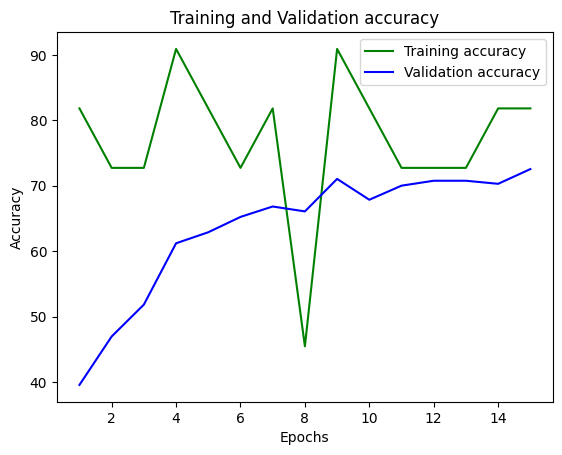

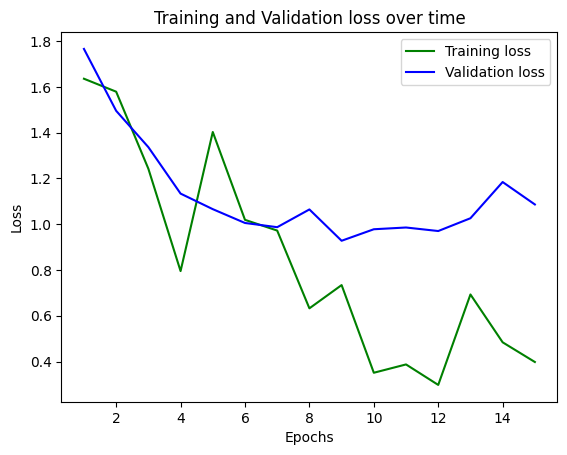

In [13]:
# Create an instance of the AlexNet model
model_dropout = AlexNet_dropout(num_classes=10).to(device)
model_dropout_weights = train_val_test_base(model_dropout,train_loader,val_loader,test_loader)

# save weights in pickle file
pickle_out = open("model_dropout.pickle", "wb")
pickle.dump(model_dropout_weights, pickle_out)
pickle_out.close()

### 3. Early stopping

Epoch [1/20], Train Loss: 1.5934, Train Accuracy: 81.82%, Val Loss: 1.6378, Val Accuracy: 39.64%
Epoch [2/20], Train Loss: 1.9465, Train Accuracy: 72.73%, Val Loss: 1.5021, Val Accuracy: 46.20%
Epoch [3/20], Train Loss: 1.4931, Train Accuracy: 81.82%, Val Loss: 1.3124, Val Accuracy: 55.01%
Epoch [4/20], Train Loss: 1.0471, Train Accuracy: 81.82%, Val Loss: 1.1784, Val Accuracy: 57.08%
Epoch [5/20], Train Loss: 0.9327, Train Accuracy: 81.82%, Val Loss: 1.0046, Val Accuracy: 64.39%
Epoch [6/20], Train Loss: 0.9091, Train Accuracy: 90.91%, Val Loss: 1.0095, Val Accuracy: 64.76%
Epoch [7/20], Train Loss: 1.0189, Train Accuracy: 81.82%, Val Loss: 0.9344, Val Accuracy: 67.48%
Epoch [8/20], Train Loss: 0.7711, Train Accuracy: 81.82%, Val Loss: 0.9925, Val Accuracy: 66.64%
Epoch [9/20], Train Loss: 0.7523, Train Accuracy: 81.82%, Val Loss: 1.0321, Val Accuracy: 66.92%
Epoch [10/20], Train Loss: 0.8287, Train Accuracy: 90.91%, Val Loss: 0.9848, Val Accuracy: 70.20%
Epoch [11/20], Train Loss: 0.

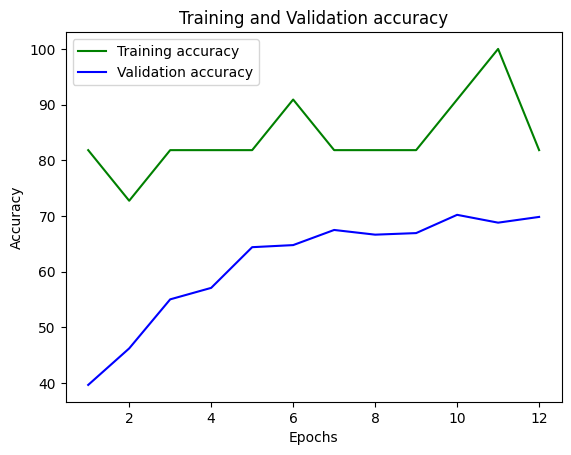

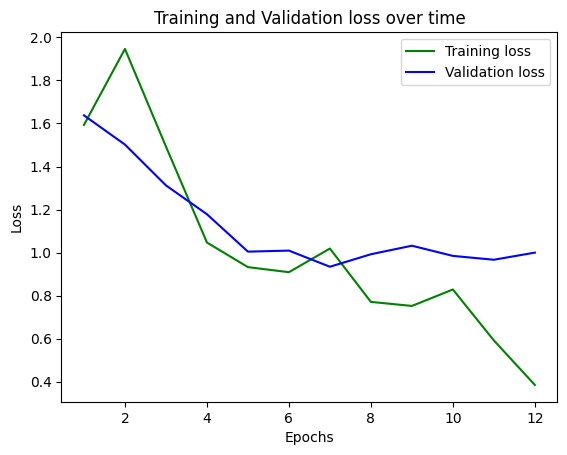

In [12]:
def train_val_test_es(model, train_loader, val_loader, test_loader, patience=5):
    # Define the hyperparameters
    learning_rate = 0.0001
    num_epochs = 20

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []
    best_val_loss = float('inf')
    best_model_state_dict = None
    early_stopping_counter = 0
    train_total = 0
    val_total = 0

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Print the training and validation loss, and accuracy for each epoch
        train_loss = loss.item()
        train_accuracy = 100.0 * (predicted == labels).sum().item() / labels.size(0)
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        val_loss /= len(val_loader)
        val_accuracy = 100.0 * val_correct / val_total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Check if validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Stop training if validation loss hasn't improved for 'patience' epochs
        if early_stopping_counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

    # Load the best model
    model.load_state_dict(best_model_state_dict)

    # Test the model
    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the test accuracy
    test_accuracy = 100.0 * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:")
    print(cm)

    # Calculate precision, recall, and F1 score
    report = classification_report(all_labels, all_predictions)
    print("Classification Report:")
    print(report)
    plot_accuracy(train_acc_list,val_acc_list)
    plot_loss(train_loss_list,val_loss_list)

    return model.state_dict()

# Create an instance of the AlexNet model
model_base = AlexNet_base(num_classes=10).to(device)
model_base.to(device)
model_es_weights = train_val_test_es(model_base, train_loader, val_loader, test_loader, patience=5)
# save weights in pickle file
pickle_out = open("model_es.pickle", "wb")
pickle.dump(model_es_weights, pickle_out)
pickle_out.close()


### 4. Image augmentation

Epoch [1/20], Train Loss: 1.1889, Train Accuracy: 100.00%, Val Loss: 0.8439, Val Accuracy: 70.67%
Epoch [2/20], Train Loss: 1.0589, Train Accuracy: 90.91%, Val Loss: 0.8657, Val Accuracy: 71.51%
Epoch [3/20], Train Loss: 1.0171, Train Accuracy: 100.00%, Val Loss: 0.8423, Val Accuracy: 71.70%
Epoch [4/20], Train Loss: 1.2719, Train Accuracy: 100.00%, Val Loss: 0.7956, Val Accuracy: 72.91%
Epoch [5/20], Train Loss: 0.5947, Train Accuracy: 81.82%, Val Loss: 0.8097, Val Accuracy: 72.63%
Epoch [6/20], Train Loss: 0.9487, Train Accuracy: 81.82%, Val Loss: 0.7684, Val Accuracy: 73.76%
Epoch [7/20], Train Loss: 0.7752, Train Accuracy: 100.00%, Val Loss: 0.7598, Val Accuracy: 73.29%
Epoch [8/20], Train Loss: 1.2996, Train Accuracy: 90.91%, Val Loss: 0.7646, Val Accuracy: 75.16%
Epoch [9/20], Train Loss: 0.7914, Train Accuracy: 100.00%, Val Loss: 0.7792, Val Accuracy: 73.66%
Epoch [10/20], Train Loss: 1.1683, Train Accuracy: 90.91%, Val Loss: 0.7296, Val Accuracy: 76.19%
Epoch [11/20], Train Los

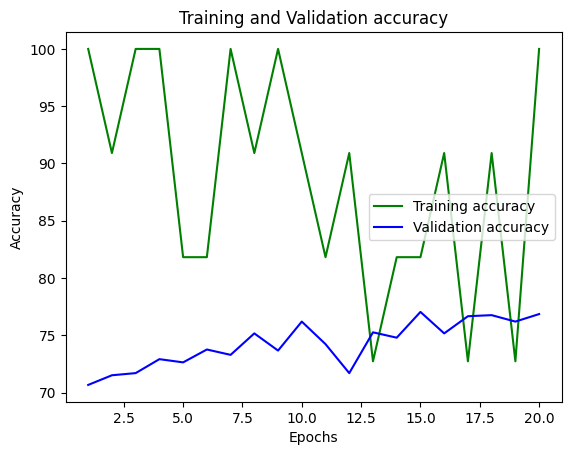

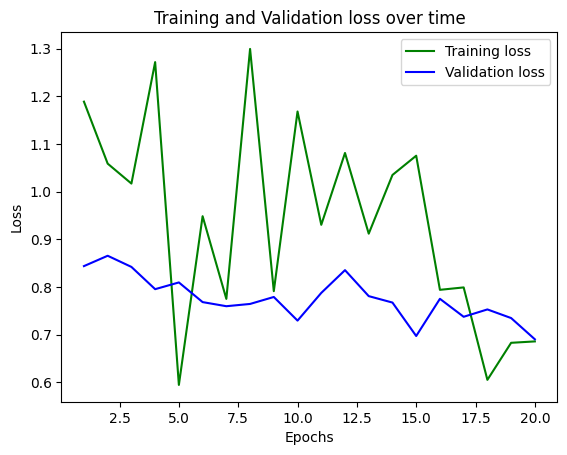

In [13]:
import torchvision.transforms as transforms

import torchvision.transforms as transforms

# Define the transformations for image preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply image augmentation to the training images
train_dataset_augmented = ImageFolder(train_dir, transform=train_transform)

# Create the data loaders
train_loader_aug = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

# Use train_loader_augmented for training instead of train_loader in the train_val_test_base function
model_aug = train_val_test_es(model_base, train_loader_aug, val_loader, test_loader, patience=5)

# save weights in pickle file
pickle_out = open("model_aug.pickle", "wb")
pickle.dump(model_aug, pickle_out)
pickle_out.close()

## References:

1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

2. https://pytorch.org/hub/pytorch_vision_alexnet/